# Chest-prediction - V2


## Setup

In [1]:
import tensorflow as tf

tf.__version__

'2.15.0'

In [2]:
AUTOTUNE = tf.data.AUTOTUNE

## Download and inspect the dataset

### Retrieve the images

Before you start any training, you'll need to download the dataset. I already resized the original dataset of the images to pass from 45GB to 3GB.

In [3]:
import os
from pathlib import Path

project_name = "chest-predictor"
username = os.environ.get('USER')

#Set variables (origin url, destination folder, folder name)
data_url = 'https://storage.googleapis.com/chest-predictor-data/resized_dataset.zip' 
data_dir = f"/Users/{username}/code/sachamagier/{project_name}/raw_data"
data_fname = 'resized_dataset.zip'


#Downloading the dataset
data_root_orig = tf.keras.utils.get_file(
    fname=os.path.join(data_dir, data_fname),
    origin=data_url
)

Unzip the dataset download from GCS

In [4]:
import zipfile

#Extract the dataset
with zipfile.ZipFile(data_root_orig, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

In [5]:
#Set the new data_root
data_root = Path(os.path.join(data_dir, 'resized_dataset'))
print(data_root)

/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset


In [6]:
#This remove the '__MACOSX' file that is created on Mac Laptops
import shutil

if Path(os.path.join(data_dir, "__MACOSX")).is_dir():
    # remove the __MACOSX folder if it exists
    shutil.rmtree("../raw_data/__MACOSX")

In [7]:
#Get all image paths
all_image_paths = [str(path) for path in (data_root/"images"/"set_full").iterdir()]

In [8]:
image_count = len(all_image_paths)
image_count

112120

In [9]:
all_image_paths[:10]

['/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00018805_001.png',
 '/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00005868_002.png',
 '/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00009663_000.png',
 '/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00022156_007.png',
 '/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00005395_004.png',
 '/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00006966_004.png',
 '/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00000324_013.png',
 '/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00007442_018.png',
 '/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/se

### Inspect the images
Now let's have a quick look at a couple of the images, so you know what you're dealing with:

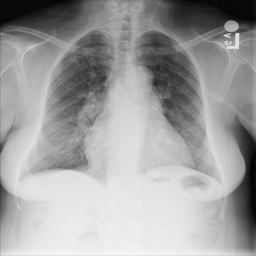

00003989_006.png



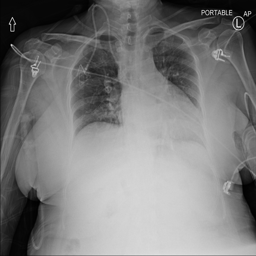

00028846_006.png



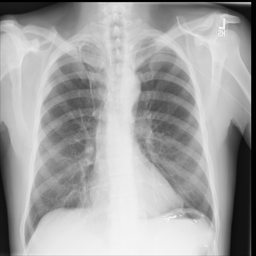

00007487_001.png



In [10]:
import IPython.display as display
import random

for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))
    print(os.path.basename(image_path))
    print()

### Determine the label for each image

Extracting the labels from the CSV

In [11]:
import pandas as pd
# Load labels
labels_df = pd.read_csv(data_root/"Data_Entry_2017.csv")
labels_df.set_index('Image Index', inplace=True)

In [12]:
labels_df.head(5)

,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
Image Index,,,,,,,,,,,
00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [13]:
# Create list of all image labels
all_image_labels = labels_df.loc[[os.path.basename(path) for path in all_image_paths], 'Finding Labels'].values

In [14]:
all_image_labels[:25]

array(['No Finding', 'No Finding', 'No Finding', 'Pneumonia',
       'No Finding', 'Pneumonia', 'No Finding', 'No Finding',
       'No Finding', 'No Finding', 'No Finding',
       'Atelectasis|Infiltration', 'Fibrosis', 'Infiltration',
       'No Finding', 'No Finding', 'No Finding', 'No Finding',
       'No Finding', 'Atelectasis', 'Infiltration|Pneumonia',
       'Cardiomegaly', 'Infiltration', 'Consolidation', 'No Finding'],
      dtype=object)

In [15]:
len(all_image_labels)

112120

#### Encoding the labels

Encoding the labels using *StringLookup*

In [16]:
#Creating a list of the 15 different labels
label_names = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'No Finding']

In [17]:
string_lookup = tf.keras.layers.StringLookup(vocabulary=label_names, num_oov_indices=0)

In [18]:
# Vectorized encoding of labels
def encode_labels(labels):
    split_labels = tf.strings.split(labels, '|')
    encoded_labels = string_lookup(split_labels)
    one_hot_encoded = tf.reduce_sum(tf.one_hot(encoded_labels, depth=len(label_names)), axis=0)
    return one_hot_encoded

In [19]:
# Apply encoding to all labels in a vectorized manner
encoded_values = tf.stack([encode_labels(labels) for labels in all_image_labels])

In [20]:
#Converting to numpy array for printing
encoded_values_np = tf.stack(encoded_values).numpy()

In [21]:
print("Encoded values:")
print(encoded_values_np[:10])

Encoded values:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [22]:
#Checking the lenght
len(encoded_values_np)

112120

If we need to find back the labels, here is the dictionnary of labels

In [23]:
vocab = string_lookup.get_vocabulary()

# Display the vocabulary and their corresponding indices
for i, label in enumerate(vocab):
    print(f"Index {i}: {label}")

Index 0: Atelectasis
Index 1: Consolidation
Index 2: Infiltration
Index 3: Pneumothorax
Index 4: Edema
Index 5: Emphysema
Index 6: Fibrosis
Index 7: Effusion
Index 8: Pneumonia
Index 9: Pleural_Thickening
Index 10: Cardiomegaly
Index 11: Nodule
Index 12: Mass
Index 13: Hernia
Index 14: No Finding


Creating a tensor Dataset

In [24]:
# Convert encoded values to tensor slices for the dataset
label_ds = tf.data.Dataset.from_tensor_slices(encoded_values)

In [25]:
label_ds

<_TensorSliceDataset element_spec=TensorSpec(shape=(15,), dtype=tf.float32, name=None)>

### Load and format the images

In [26]:
img_path = all_image_paths[0]
img_path

'/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00018805_001.png'

here is the raw data:

In [27]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: shape=(), dtype=string, numpy=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x00\x00\...


Decode it into an image tensor:

In [28]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(256, 256, 1)
<dtype: 'uint8'>


Let's wrap up these up in simple functions for later.

In [32]:
def preprocess_image(image):
    # convert it to rgb => VGG16 takes RGB image only
    image = tf.image.grayscale_to_rgb(image)

    # Resize the image to a width and a height of 256 pixels
    image = tf.image.resize(image, [256, 256], method='nearest') #=> ALREADY SIZED
    # Normalize the pixel values of the image to the range of [0, 1] => WE DON'T NEED FOR VGG16
    image /= 255

    return image

In [33]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    # Decode the image contents
    img_tensor = tf.image.decode_png(image)[:,:,0:1]
    return preprocess_image(img_tensor)

In [34]:
image1 = load_and_preprocess_image(all_image_paths[0])
image1

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[0.13333334, 0.13333334, 0.13333334],
        [0.05490196, 0.05490196, 0.05490196],
        [0.01568628, 0.01568628, 0.01568628],
        ...,
        [0.00392157, 0.00392157, 0.00392157],
        [0.00784314, 0.00784314, 0.00784314],
        [0.00784314, 0.00784314, 0.00784314]],

       [[0.13333334, 0.13333334, 0.13333334],
        [0.05490196, 0.05490196, 0.05490196],
        [0.01568628, 0.01568628, 0.01568628],
        ...,
        [0.00392157, 0.00392157, 0.00392157],
        [0.00784314, 0.00784314, 0.00784314],
        [0.00784314, 0.00784314, 0.00784314]],

       [[0.12941177, 0.12941177, 0.12941177],
        [0.05098039, 0.05098039, 0.05098039],
        [0.01568628, 0.01568628, 0.01568628],
        ...,
        [0.00392157, 0.00392157, 0.00392157],
        [0.00784314, 0.00784314, 0.00784314],
        [0.00784314, 0.00784314, 0.00784314]],

       ...,

       [[0.20784314, 0.20784314, 0.20784314],
        [0.16

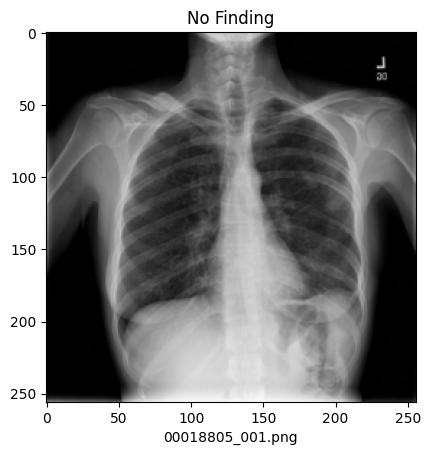

In [35]:
import matplotlib.pyplot as plt

img_path = all_image_paths[0]
label = all_image_labels[0]
encoded_lab = encoded_values[0]

plt.imshow(load_and_preprocess_image(img_path), cmap="gray")
plt.grid(False)
plt.xlabel(os.path.basename(img_path))
plt.title(label.title())
print()

## Build a `tf.data.Dataset`

### A dataset of images

The easiest way to build a tf.data.Dataset is using the from_tensor_slices method.

Slicing the array of strings results in a dataset of strings:

In [36]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

In [37]:
path_ds

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [38]:
for p in path_ds.take(4):
    print(p)

tf.Tensor(b'/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00018805_001.png', shape=(), dtype=string)
tf.Tensor(b'/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00005868_002.png', shape=(), dtype=string)
tf.Tensor(b'/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00009663_000.png', shape=(), dtype=string)
tf.Tensor(b'/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00022156_007.png', shape=(), dtype=string)


Now create a new dataset that loads and formats images on the fly by mapping `preprocess_image` over the dataset of paths.

In [39]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

In [40]:
image1 = image_ds.take(2)
for i in image1:
    print(i)

tf.Tensor(
[[[0.13333334 0.13333334 0.13333334]
  [0.05490196 0.05490196 0.05490196]
  [0.01568628 0.01568628 0.01568628]
  ...
  [0.00392157 0.00392157 0.00392157]
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]]

 [[0.13333334 0.13333334 0.13333334]
  [0.05490196 0.05490196 0.05490196]
  [0.01568628 0.01568628 0.01568628]
  ...
  [0.00392157 0.00392157 0.00392157]
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]]

 [[0.12941177 0.12941177 0.12941177]
  [0.05098039 0.05098039 0.05098039]
  [0.01568628 0.01568628 0.01568628]
  ...
  [0.00392157 0.00392157 0.00392157]
  [0.00784314 0.00784314 0.00784314]
  [0.00784314 0.00784314 0.00784314]]

 ...

 [[0.20784314 0.20784314 0.20784314]
  [0.16470589 0.16470589 0.16470589]
  [0.16470589 0.16470589 0.16470589]
  ...
  [0.05098039 0.05098039 0.05098039]
  [0.08627451 0.08627451 0.08627451]
  [0.12156863 0.12156863 0.12156863]]

 [[0.31764707 0.31764707 0.31764707]
  [0.28235295 0.28235295 0

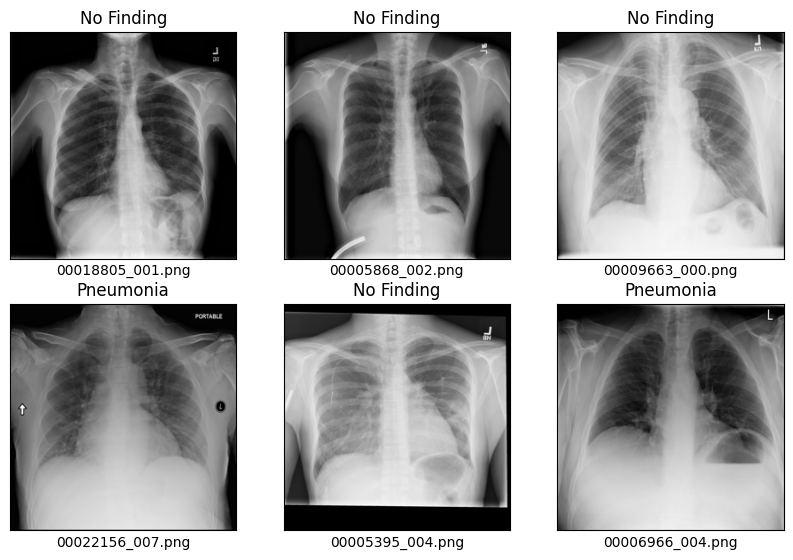

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for n,image in enumerate(image_ds.take(6)):
    ax = plt.subplot(3,3,n+1)
    plt.imshow(image, cmap='gray')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(os.path.basename(all_image_paths[n]))
    plt.title(all_image_labels[n].title())

plt.show()

### A dataset of `(image, label)` pairs


Using the same `from_tensor_slices` method you can build a dataset of labels

In [42]:
#label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(encoded_values, tf.int32))

In [43]:
for label in label_ds.take(10):
  print(label)

tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(15,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(15,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(15,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(15,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(15,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(15,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(15,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(15,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(15,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(15,), dtype=float32)


We have arrays `all_image_labels` and `all_image_paths` so We can use `tf.data.dataset.Dataset.zip` to slicing the pair of arrays.

In [44]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, encoded_values))

# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<_MapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(15,), dtype=tf.float32, name=None))>

### Basic methods for training


To train a model with this dataset we want the data:

* To be well shuffled.
* To be batched.
* To repeat forever.
* To have batches available as soon as possible.

These features can be easily added using the `tf.data` api.

In [45]:
BATCH_SIZE = 32

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
#ds = image_label_ds.shuffle(buffer_size=image_count)
ds = image_label_ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>

In [46]:
ds.take(6)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>

### Creating X and y (train, val and test)

In [74]:
train_size = int(0.6 * len(all_image_paths))
val_size = int(0.2 * len(all_image_paths))
test_size = int(0.2 * len(all_image_paths))

In [75]:
train_ds = ds.take(train_size)

In [76]:
val_ds = ds.skip(train_size).take(val_size)

In [77]:
test_ds = ds.skip(train_size + val_size).take(test_size)

### Pipe the dataset to a model

Metrics

In [78]:
auc = tf.keras.metrics.AUC(multi_label=True)

Model

In [79]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3), include_top=False)
mobile_net.trainable=False

In [80]:
def change_range(image,label):
  return 2*image-1, label

keras_ds = ds.map(change_range)

In [81]:
# The dataset may take a few seconds to start, as it fills its shuffle buffer.
image_batch, label_batch = next(iter(keras_ds))

In [82]:
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

(32, 8, 8, 1280)


In [83]:
model = tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names), activation = 'sigmoid')])

In [84]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: 0.037418753
max logit: 0.9269102

Shape: (32, 15)


In [85]:
from tensorflow.keras import optimizers
model.compile(optimizer=optimizers.legacy.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=["accuracy", auc])

In [86]:

len(model.trainable_variables)

2

In [87]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 15)                19215     
                                                                 
Total params: 2277199 (8.69 MB)
Trainable params: 19215 (75.06 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [88]:
steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

3504.0

In [89]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='accuracy', #'val_multilabel_f1_score',  # the name of the metric will be its prefix + '_' + its function name
                   mode='max',
                   patience=2,
                   verbose=1,
                   restore_best_weights=True)

In [ ]:
EPOCHS = 3

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=[es])


Epoch 1/3
  76/3504 [..............................] - ETA: 12:44 - loss: 0.4097 - accuracy: 0.3113 - auc_2: 0.4865

In [63]:
history

import tensorflow as tf

tf.__version__
AUTOTUNE = tf.data.AUTOTUNE
import os
from pathlib import Path

project_name = "chest-predictor"
username = os.environ.get('USER')

#Set variables (origin url, destination folder, folder name)
data_url = 'https://storage.googleapis.com/chest-predictor-data/resized_dataset.zip' 
data_dir = f"/Users/{username}/code/sachamagier/{project_name}/raw_data"
data_fname = 'resized_dataset.zip'


#Downloading the dataset
data_root_orig = tf.keras.utils.get_file(
    fname=os.path.join(data_dir, data_fname),
    origin=data_url
)
import zipfile

#Extract the dataset
with zipfile.ZipFile(data_root_orig, 'r') as zip_ref:
    zip_ref.extractall(data_dir)
#Set the new data_root
data_root = Path(os.path.join(data_dir, 'resized_dataset'))
print(data_root)
#This remove the '__MACOSX' file that is created on Mac Laptops
import shutil

if Path(os.path.join(data_dir, "__MACOSX")).is_dir():
    # remove the __MACOSX folder if it exists
    shutil.rmtree("../raw_data/__

In [ ]:
results = model.evaluate(test_ds, verbose=0)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")
print(f"Test AUC: {results[2]}")